In [348]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [349]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [350]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [352]:
gpus

[]

In [353]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [354]:
# Make the directories
os.makedirs(POS_PATH,exist_ok=True)
os.makedirs(NEG_PATH,exist_ok=True)
os.makedirs(ANC_PATH,exist_ok=True)

In [356]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [357]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [359]:
# Import uuid library to generate unique image names
import uuid

In [360]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\bfdaa0db-8b50-11ef-838d-541379c12a44.jpg'

In [361]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [628]:
# plt.imshow(frame[120:120+250,200:200+250, :])

In [441]:
anchor = tf.data.Dataset.list_files(f'{ANC_PATH}/*.jpg').take(300)
positive = tf.data.Dataset.list_files(f'{POS_PATH}/*.jpg').take(300)
negative = tf.data.Dataset.list_files(f'{NEG_PATH}/*.jpg').take(300)

In [443]:
dir_test = anchor.as_numpy_iterator()

In [445]:
print(dir_test.next())

b'data\\anchor\\83a58da2-8b3f-11ef-b1ff-541379c12a44.jpg'


In [447]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [451]:
img = preprocess('data\\anchor\\83a58da2-8b3f-11ef-b1ff-541379c12a44.jpg')

In [453]:
img.numpy().max() 

0.78063726

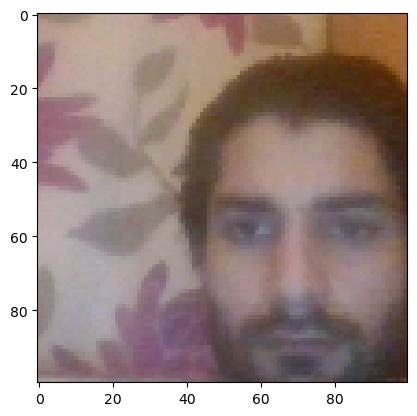

In [455]:
plt.imshow(img)

In [458]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [460]:
samples = data.as_numpy_iterator()

In [461]:
exampple = samples.next()

In [464]:
exampple

(b'data\\anchor\\3119ae76-8b29-11ef-894d-541379c12a44.jpg',
 b'data\\positive\\daa0f35d-8b23-11ef-8f86-541379c12a44.jpg',
 1.0)

In [466]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [468]:
res = preprocess_twin(*exampple)

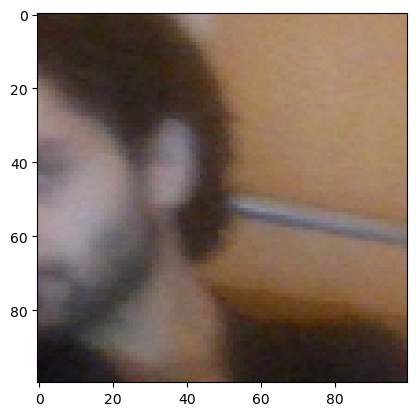

In [470]:
plt.imshow(res[1])

In [471]:

res[2]

1.0

In [474]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [475]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [478]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [630]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [494]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [497]:
embedding = make_embedding()

In [498]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [499]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        # Make sure to convert input_embedding and validation_embedding to tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)


In [502]:
l1 = L1Dist()

In [506]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
embedding(input_image)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_109>]

In [507]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [509]:
siamese_layer = L1Dist()

In [510]:
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier


<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_113>

In [511]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [512]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_11 (L1Dist)           │ (1, None, 4096)           │               0 │ embedding[1][0],           │
│                               │                           │                 │ embedding[2][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (1, None, 1)              │           4,097 │ l1_dist_11[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [513]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [515]:
siamese_model = make_siamese_model()

In [517]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_12 (L1Dist)           │ (1, None, 4096)           │               0 │ embedding[3][0],           │
│                               │                           │                 │ embedding[4][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (1, None, 1)              │           4,097 │ l1_dist_12[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [524]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [525]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [527]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [531]:
test_batch = train_data.as_numpy_iterator()

In [533]:
batch_1 = test_batch.next()

In [534]:
X = batch_1[:2]

In [535]:
y = batch_1[2]

In [536]:
y

array([0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [538]:
import os
import tensorflow as tf

# Define the loss function and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)  # Adam optimizer with learning rate 0.0001

# Checkpoint to save the model during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Load a batch of data
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

# Input images and labels from the batch
X = batch_1[:2]  # First two elements are the input images
y = batch_1[2]  # The third element is the label (0 or 1 for similarity)

# Reshape y_pred to match y's shape
with tf.GradientTape() as tape:
    # Pass the input images through the siamese model
    y_pred = siamese_model(X, training=True)
    
    # Reshape y_pred to match y_true shape
    y_pred = tf.squeeze(y_pred)  # Remove the extra dimensions, if needed
    
    # Compute the loss
    loss = binary_cross_loss(y, y_pred)

# Compute the gradients and apply them
grads = tape.gradient(loss, siamese_model.trainable_variables)
opt.apply_gradients(zip(grads, siamese_model.trainable_variables))

# Save checkpoint
checkpoint.save(file_prefix=checkpoint_prefix)

# Print the loss for the current step
print(f"Loss: {loss.numpy()}")


Loss: 0.6926361322402954


In [551]:
def train_step(batch):
    X = batch[:2]  # Input images
    y = batch[2]   # Labels (0 or 1)

    with tf.GradientTape() as tape:
        # Make predictions
        y_pred = siamese_model(X, training=True)
        
        # Squeeze y_pred to match y's shape
        y_pred = tf.squeeze(y_pred)  # Remove extra dimensions if needed
        
        # Compute the binary cross-entropy loss
        loss = binary_cross_loss(y, y_pred)

    # Print loss to verify
    print(f"Loss: {loss.numpy()}")

    # Compute gradients and update the model
    grads = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grads, siamese_model.trainable_variables))

    # Save checkpoint if needed
    checkpoint.save(file_prefix=checkpoint_prefix)


In [553]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [555]:
EPOCHS = 50

In [557]:
train(train_data, EPOCHS)


 Epoch 1/50
Loss: 0.6469889879226685
 1/27 ━━━━━━━━━━━━━━━━━━━━ 22:26 52s/stepLoss: 0.5811552405357361
 2/27 ━━━━━━━━━━━━━━━━━━━━ 27:17 66s/stepLoss: 0.47609418630599976
 3/27 ━━━━━━━━━━━━━━━━━━━━ 24:48 62s/stepLoss: 0.42159605026245117
 4/27 ━━━━━━━━━━━━━━━━━━━━ 22:03 58s/stepLoss: 0.446357786655426
 5/27 ━━━━━━━━━━━━━━━━━━━━ 20:41 56s/stepLoss: 0.42296358942985535
 6/27 ━━━━━━━━━━━━━━━━━━━━ 19:44 56s/stepLoss: 0.2682090401649475
 7/27 ━━━━━━━━━━━━━━━━━━━━ 18:20 55s/stepLoss: 0.33322733640670776
 8/27 ━━━━━━━━━━━━━━━━━━━━ 17:21 55s/stepLoss: 0.5573201179504395
 9/27 ━━━━━━━━━━━━━━━━━━━━ 16:14 54s/stepLoss: 0.4688165485858917
10/27 ━━━━━━━━━━━━━━━━━━━━ 15:10 54s/stepLoss: 0.4567844867706299
11/27 ━━━━━━━━━━━━━━━━━━━━ 14:11 53s/stepLoss: 0.32913321256637573
12/27 ━━━━━━━━━━━━━━━━━━━━ 13:22 53s/stepLoss: 0.3489096760749817
13/27 ━━━━━━━━━━━━━━━━━━━━ 12:33 54s/stepLoss: 0.3650864064693451
14/27 ━━━━━━━━━━━━━━━━━━━━ 11:32 53s/stepLoss: 0.3698039948940277
15/27 ━━━━━━━━━━━━━━━━━━━━ 10:39 5

In [559]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [561]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [563]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


array([[[1.7378922e-04],
        [4.5520991e-08],
        [1.0000000e+00],
        [8.3733902e-08],
        [3.5949375e-07],
        [5.2524723e-07],
        [1.7177247e-07],
        [9.9999976e-01],
        [1.0000000e+00],
        [9.9999797e-01],
        [5.8269006e-08],
        [9.9999982e-01],
        [3.3461320e-06],
        [7.3877851e-07],
        [1.2861062e-05],
        [3.6332029e-05]]], dtype=float32)

In [567]:
import tensorflow as tf

# Assuming y_hat is a TensorFlow tensor
predictions = tf.where(y_hat > 0.5, 1, 0)


In [569]:
y_true

array([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [571]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [573]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

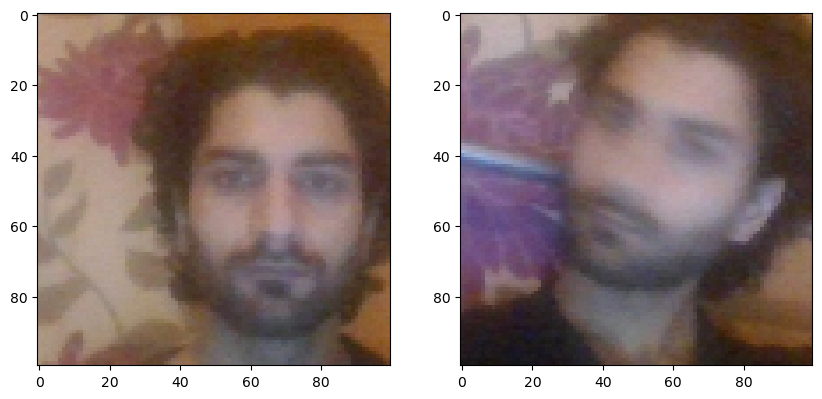

In [584]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [586]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [588]:
L1Dist

__main__.L1Dist

In [590]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [592]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[[1.7378922e-04],
        [4.5520991e-08],
        [1.0000000e+00],
        [8.3733902e-08],
        [3.5949375e-07],
        [5.2524723e-07],
        [1.7177247e-07],
        [9.9999976e-01],
        [1.0000000e+00],
        [9.9999797e-01],
        [5.8269006e-08],
        [9.9999982e-01],
        [3.3461320e-06],
        [7.3877851e-07],
        [1.2861062e-05],
        [3.6332029e-05]]], dtype=float32)

In [593]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_12 (L1Dist)           │ (1, None, 4096)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (1, None, 1)              │           4,097 │ l1_dist_12[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [612]:
 r'application_data\verification_images'


'application_data\\verification_images'

In [614]:
os.listdir(os.path.join('application_data', 'verification_images'))

['002beb9d-8b48-11ef-b4bd-541379c12a44.jpg',
 '3a0539cc-8b29-11ef-878b-541379c12a44.jpg',
 '3a135923-8b29-11ef-af66-541379c12a44.jpg',
 '3a21af87-8b29-11ef-a217-541379c12a44.jpg',
 '3a36fc25-8b29-11ef-b52d-541379c12a44.jpg',
 '3a587c1e-8b29-11ef-bfab-541379c12a44.jpg',
 '3a72c020-8b29-11ef-b9f6-541379c12a44.jpg',
 '3a8131b3-8b29-11ef-ba4f-541379c12a44.jpg',
 '3a8fb8d6-8b29-11ef-9079-541379c12a44.jpg',
 '3ab38cc8-8b29-11ef-ac5f-541379c12a44.jpg',
 '3afa045b-8b29-11ef-9126-541379c12a44.jpg',
 '3c3f26f9-8b29-11ef-8b07-541379c12a44.jpg',
 '3ca7e1ef-8b29-11ef-a71b-541379c12a44.jpg',
 '3ce07201-8b29-11ef-9255-541379c12a44.jpg',
 '3d01f9ee-8b29-11ef-bbdd-541379c12a44.jpg',
 'c4876c57-8b3d-11ef-9eae-541379c12a44.jpg',
 'c4957de3-8b3d-11ef-83c3-541379c12a44.jpg',
 'c53646d9-8b3d-11ef-8c5f-541379c12a44.jpg',
 'c5680dfc-8b3d-11ef-80c0-541379c12a44.jpg',
 'c6593545-8b3d-11ef-b024-541379c12a44.jpg',
 'c6860ae0-8b3d-11ef-be77-541379c12a44.jpg',
 'c7302b2a-8b3d-11ef-9ed3-541379c12a44.jpg',
 'c7373f0a

In [616]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [618]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\002beb9d-8b48-11ef-b4bd-541379c12a44.jpg
application_data\verification_images\3a0539cc-8b29-11ef-878b-541379c12a44.jpg
application_data\verification_images\3a135923-8b29-11ef-af66-541379c12a44.jpg
application_data\verification_images\3a21af87-8b29-11ef-a217-541379c12a44.jpg
application_data\verification_images\3a36fc25-8b29-11ef-b52d-541379c12a44.jpg
application_data\verification_images\3a587c1e-8b29-11ef-bfab-541379c12a44.jpg
application_data\verification_images\3a72c020-8b29-11ef-b9f6-541379c12a44.jpg
application_data\verification_images\3a8131b3-8b29-11ef-ba4f-541379c12a44.jpg
application_data\verification_images\3a8fb8d6-8b29-11ef-9079-541379c12a44.jpg
application_data\verification_images\3ab38cc8-8b29-11ef-ac5f-541379c12a44.jpg
application_data\verification_images\3afa045b-8b29-11ef-9126-541379c12a44.jpg
application_data\verification_images\3c3f26f9-8b29-11ef-8b07-541379c12a44.jpg
application_data\verification_images\3ca7e1ef-8b29-11ef-a71b-541

In [620]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [624]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [626]:
np.sum(np.squeeze(results) > 0.9)

49